# Atari

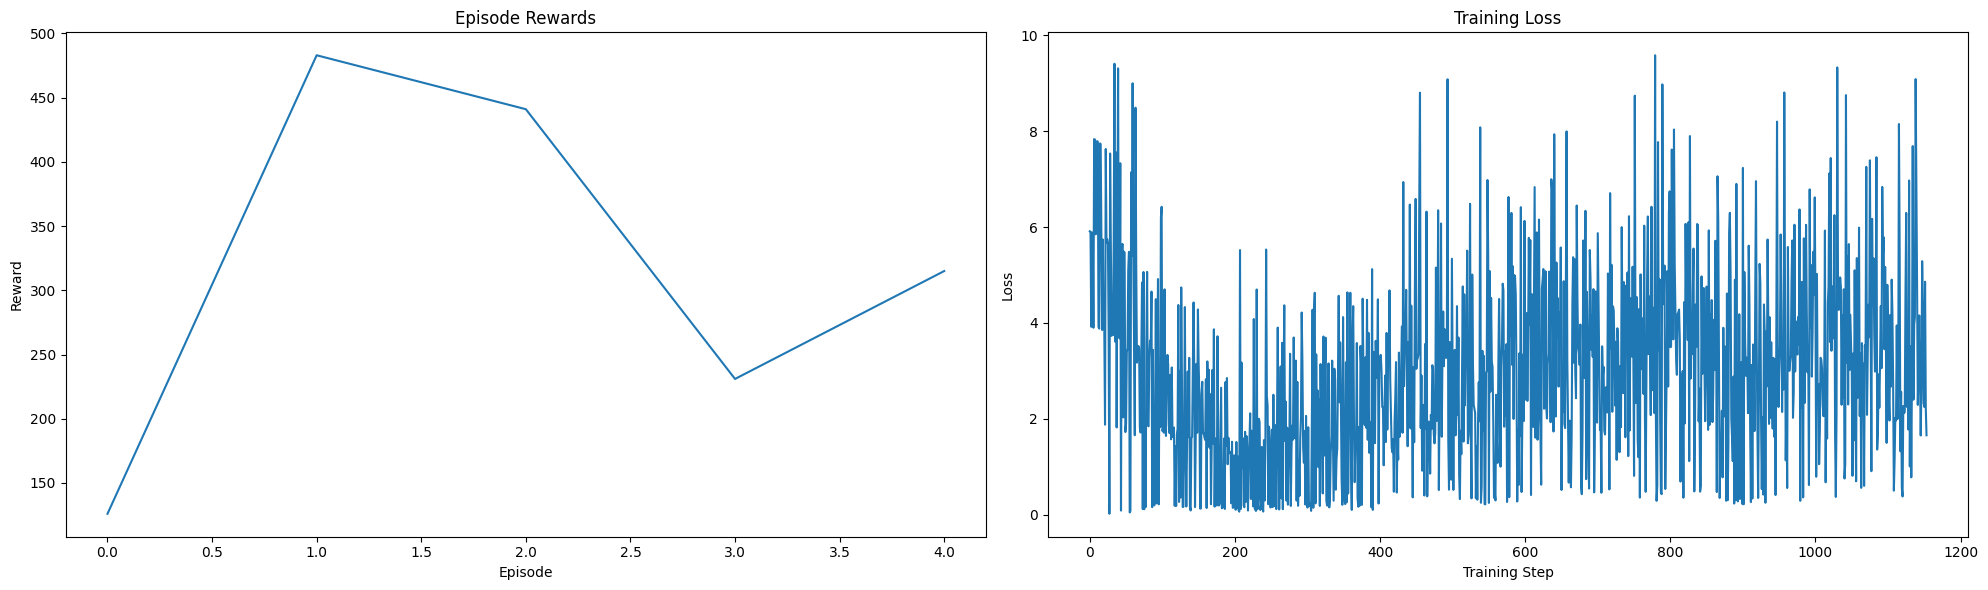

Episode: 5/5, Reward: 315.0, Epsilon: 0.0997


2025-03-17 12:28:56.130 Python[10016:1668622] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-17 12:28:56.130 Python[10016:1668622] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Test Episode: 1/3, Total Reward: 189.0
Test Episode: 2/3, Total Reward: 294.0
Test Episode: 3/3, Total Reward: 420.0


In [ ]:
import gymnasium as gym
import ale_py
import numpy as np
import random
import cv2
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

# Fix potential TensorFlow GPU memory issue
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

class AssaultDQNAgent:
    def __init__(
        self,
        env_name='ALE/Assault-v5',
        frame_skip=4,
        memory_size=10000,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.1,
        epsilon_decay=0.995,
        learning_rate=0.0001,
        batch_size=32,
        update_target_freq=1000
    ):
        # Environment setup
        self.env = gym.make(env_name, render_mode=None)
        self.action_size = self.env.action_space.n
        self.frame_skip = frame_skip
        
        # Agent parameters
        self.memory = deque(maxlen=memory_size)
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.update_target_freq = update_target_freq
        self.frame_stack_size = 4
        
        # Build networks
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        
        # Metrics
        self.rewards_history = []
        self.loss_history = []
        self.steps = 0
    
    def _build_model(self):
        """Build a CNN model for DQN using the Input layer as recommended"""
        model = Sequential([
            # Using Input layer first as recommended in the warning
            Input(shape=(84, 84, self.frame_stack_size)),
            Conv2D(16, (8, 8), strides=4, activation='relu'),
            Conv2D(32, (4, 4), strides=2, activation='relu'),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(self.action_size)
        ])
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model
    
    def update_target_model(self):
        """Update target network weights from the main network"""
        self.target_model.set_weights(self.model.get_weights())
    
    def preprocess_frame(self, frame):
        """Preprocess the observation frame"""
        # Convert to grayscale and resize
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
        # Normalize
        return resized / 255.0
    
    def stack_frames(self, frames):
        """Stack frames together to create a state"""
        return np.stack(frames, axis=2)
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in memory"""
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        """Choose action based on epsilon-greedy policy"""
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])
    
    def replay(self):
        """Train on batch of experiences"""
        if len(self.memory) < self.batch_size:
            return 0
        
        # Sample batch from memory
        minibatch = random.sample(self.memory, self.batch_size)
        
        states = np.zeros((self.batch_size, 84, 84, self.frame_stack_size))
        next_states = np.zeros((self.batch_size, 84, 84, self.frame_stack_size))
        actions, rewards, dones = [], [], []
        
        # Fill arrays
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            states[i] = state
            next_states[i] = next_state
            actions.append(action)
            rewards.append(reward)
            dones.append(done)
        
        # Predict Q-values
        targets = self.model.predict(states, verbose=0)
        next_q_values = self.target_model.predict(next_states, verbose=0)
        
        # Update Q-values for actions taken
        for i in range(self.batch_size):
            if dones[i]:
                targets[i, actions[i]] = rewards[i]
            else:
                targets[i, actions[i]] = rewards[i] + self.gamma * np.amax(next_q_values[i])
        
        # Train the model
        history = self.model.fit(states, targets, epochs=1, verbose=0, batch_size=self.batch_size)
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        return history.history['loss'][0]
    
    def train(self, episodes=100, max_steps=10000, plot_freq=10):
        """Training loop"""
        for episode in range(episodes):
            # Reset environment
            observation, _ = self.env.reset()
            
            # Stack initial frames
            frame_stack = deque(maxlen=self.frame_stack_size)
            processed_frame = self.preprocess_frame(observation)
            for _ in range(self.frame_stack_size):
                frame_stack.append(processed_frame)
            
            state = self.stack_frames(frame_stack)
            total_reward = 0
            
            for step in range(max_steps):
                # Choose action
                action = self.act(state)
                
                # Skip frames and accumulate reward
                accumulated_reward = 0
                for _ in range(self.frame_skip):
                    observation, reward, terminated, truncated, _ = self.env.step(action)
                    accumulated_reward += reward
                    if terminated or truncated:
                        break
                
                done = terminated or truncated
                
                # Process new frame
                new_frame = self.preprocess_frame(observation)
                frame_stack.append(new_frame)
                next_state = self.stack_frames(frame_stack)
                
                # Store transition
                self.remember(state, action, accumulated_reward, next_state, done)
                
                # Update state and total reward
                state = next_state
                total_reward += accumulated_reward
                
                # Perform experience replay
                loss = self.replay()
                if loss > 0:
                    self.loss_history.append(loss)
                
                # Update target network periodically
                self.steps += 1
                if self.steps % self.update_target_freq == 0:
                    self.update_target_model()
                
                if done:
                    break
            
            # Store episode reward
            self.rewards_history.append(total_reward)
            
            # Plot progress periodically
            if (episode + 1) % plot_freq == 0:
                self.plot_progress()
                
            print(f"Episode: {episode+1}/{episodes}, Reward: {total_reward}, Epsilon: {self.epsilon:.4f}")
    
    def plot_progress(self):
        """Plot rewards and loss history"""
        clear_output(wait=True)
        plt.figure(figsize=(20, 6))
        
        # Plot rewards
        plt.subplot(1, 2, 1)
        plt.plot(self.rewards_history)
        plt.title('Episode Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        
        # Plot loss
        if self.loss_history:
            plt.subplot(1, 2, 2)
            plt.plot(self.loss_history)
            plt.title('Training Loss')
            plt.xlabel('Training Step')
            plt.ylabel('Loss')
        
        plt.tight_layout()
        plt.show()
    
    def save_model(self, filepath):
        """Save the trained model"""
        self.model.save(filepath)
    
    def load_model(self, filepath):
        """Load a trained model"""
        self.model = tf.keras.models.load_model(filepath)
        self.update_target_model()
    
    def test(self, episodes=5, render=False):
        """Test the agent"""
        if render:
            test_env = gym.make(self.env.unwrapped.spec.id, render_mode='human')
        else:
            test_env = self.env
            
        for episode in range(episodes):
            observation, _ = test_env.reset()
            
            # Stack initial frames
            frame_stack = deque(maxlen=self.frame_stack_size)
            processed_frame = self.preprocess_frame(observation)
            for _ in range(self.frame_stack_size):
                frame_stack.append(processed_frame)
            
            state = self.stack_frames(frame_stack)
            done = False
            total_reward = 0
            
            while not done:
                # Choose action (no exploration)
                state_tensor = np.expand_dims(state, axis=0)
                q_values = self.model.predict(state_tensor, verbose=0)
                action = np.argmax(q_values[0])
                
                # Skip frames and accumulate reward
                accumulated_reward = 0
                for _ in range(self.frame_skip):
                    observation, reward, terminated, truncated, _ = test_env.step(action)
                    accumulated_reward += reward
                    if terminated or truncated:
                        break
                
                done = terminated or truncated
                
                # Process new frame
                new_frame = self.preprocess_frame(observation)
                frame_stack.append(new_frame)
                state = self.stack_frames(frame_stack)
                
                total_reward += accumulated_reward
                
                if render:
                    time.sleep(0.01)  # Slow down rendering
            
            print(f"Test Episode: {episode+1}/{episodes}, Total Reward: {total_reward}")
        
        if render:
            test_env.close()


# Example usage
def run_assault_dqn():
    # Create an agent for Assault
    agent = AssaultDQNAgent(
        env_name='ALE/Assault-v5',
        frame_skip=4,
        memory_size=10000,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.1,
        epsilon_decay=0.995,
        learning_rate=0.0001,
        batch_size=32,
        update_target_freq=1000
    )
    
    # Train the agent
    agent.train(episodes=50, max_steps=10000, plot_freq=5)
    
    # Save the trained model
    agent.save_model("assault_dqn_model.h5")
    
    # Test the agent
    agent.test(episodes=3, render=True)  # Set render=True to visualize gameplay

# Run the example
if __name__ == "__main__":
    run_assault_dqn()